Model 2: Ricker grozth, fractional parasitism

Original Model:
$$\\ h_{t+1} = h_{t}e^{r(1-h_{t})}(\frac{1}{1+p_{t}})$$
$$\\ p_{t+1} = bh_{t}e^{r(1-h_{t})}(\frac{p_{t}}{1+p_{t}})$$

Lagged (3D) Model:
$$\\ x_{t+1} = y_{t}$$
$$\\ y_{t+1} = y_{t}e^{r(1-x_{t})}(\frac{1}{1+z_{t}})$$
$$\\ z_{t+1} = by_{t}e^{r(1-x_{t})}(\frac{z_{t}}{1+z_{t}})$$

In [1]:
from sympy import *
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
init_printing(wrap_line=False)

x, y, z, r, b = symbols('x y z r b', real=True)

f1 = y
f2 = y*exp(r*(1-x))*(1/(1+z))
f3 = b*y*exp(r*(1-x))*(z/(1+z))

def set_pos(sym):
    return symbols(str(sym), positive=True)

def posify_list(expr):
    return [expr[i].subs(b,set_pos(b)) for i in range(len(expr))]

def simplify_list(list):
    return [simplify(el.subs(b,set_pos(b))) for el in list]

fixed_points = solve([f1-x, f2-y, f3-z],[x,y,z])
comm_fp = posify_list(fixed_points[2])
map = Matrix([f1,f2,f3])
jac = map.jacobian([x,y,z])

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

def clutch(b):
    return b

def ricker_growth(r,x):
    return np.exp(r*(1-x))

def frac_decay(z):
    return 1/(1+z)


def orbit(x0, y0, z0, r, b, its, k):
    x = [x0]
    y = [y0]
    z = [z0]
    i = 1
    while i <= its:
        next_x = y[i-1]
        next_y = y[i-1]*ricker_growth(r,x[i-1])*frac_decay(z[i-1])
        next_z = y[i-1]*clutch(b)*ricker_growth(r,x[i-1])*z[i-1]*(frac_decay(z[i-1]))
        x.append(next_x)
        y.append(next_y)
        z.append(next_z)
        i += 1
    return x[-k:], y[-k:], z[-k:]

def sim_mat(M):
    new_mat = zeros(3,3)
    NI, NJ = M.shape
    for i in range(NI):
        for j in range(NJ):
            new_mat[i,j] = simplify(M[i,j])
    return new_mat

comm_mat = jac.subs([(x,comm_fp[0]),(y,comm_fp[1]), (z,comm_fp[2])])
comm_mat_simple = sim_mat(comm_mat)
chareq = comm_mat_simple.charpoly()
a0, a1, a2, a3 = simplify_list(chareq.coeffs())

# Jury Conditions
jury1 = simplify(1 + a1 + a2 + a3)
jury2 = simplify(1 - a1 + a2 - a3)
jury3 = simplify(3 + a1 - a2 -3*a3)
jury4 = simplify(1 + a1*a3 -a2 - a3**2)

ineq1 = jury1>0
ineq2 = jury2>0
ineq3 = jury3>0
ineq4 = jury4>0

jury1num = lambdify([b,r],jury1,"numpy")
jury2num = lambdify([b,r],jury2,"numpy")
jury3num = lambdify([b,r],jury3,"numpy")
jury4num = lambdify([b,r],jury4,"numpy")

zero_mat = jac.subs([(x,0),(y,0), (z,0)])
ext_mat = jac.subs([(x,1),(y,1), (z,0)])

zero_char_eq = sim_mat(zero_mat).charpoly()
ext_char_eq =sim_mat(ext_mat).charpoly()

zero_char_coeffs = simplify_list(zero_char_eq.coeffs())
ext_char_coeffs = simplify_list(ext_char_eq.coeffs())

zpt_coeffs = [1,-exp(r),0,0]
extpt_coeffs = [1,-b-1,b+r,-b*r]

def print_eigs(points):
    for pt in points:
        mat_num = lambdify([b,r],comm_mat_simple,"numpy")
        mat = mat_num(pt[0],pt[1]).astype(np.float64)
        ptstr = "("+str(pt[0])+","+str(pt[1])+")"
        eigs = np.round(np.linalg.eigvals(mat),5)
        print(ptstr)
        print(eigs)
        print("modulus of eigs")
        print([np.round(abs(eig),5) for eig in eigs])
        print("*******\n")

def juries(coeffs):
    a0, a1, a2, a3 = coeffs
    jury1 = simplify(1 + a1 + a2 + a3)
    jury2 = simplify(1 - a1 + a2 - a3)
    jury3 = simplify(3 + a1 - a2 -3*a3)
    jury4 = simplify(1 + a1*a3 -a2 - a3**2)
    return jury1, jury2, jury3, jury4

def ineqs(juries):
    ineq1 = juries[0]>0
    ineq2 = juries[1]>0
    ineq3 = juries[2]>0
    ineq4 = juries[3]>0
    return ineq1, ineq2, ineq3, ineq4

def juries_to_num(juries):
    jury1num = lambdify([b,r],juries[0],"numpy")
    jury2num = lambdify([b,r],juries[1],"numpy")
    jury3num = lambdify([b,r],juries[2],"numpy")
    jury4num = lambdify([b,r],juries[3],"numpy")
    return jury1num, jury2num, jury3num, jury4num

def is_stable_pt(coeffs):
    a0, a1, a2, a3 = coeffs
    jury1 = 1 + a1 + a2 + a3
    jury2 = 1 - a1 + a2 - a3
    jury3 = 3 + a1 - a2 -3*a3
    jury4 = 1 + a1*a3 -a2 - a3**2
    return jury1>0 and jury2>0 and jury3>0 and jury4>0

def is_comm_stable(b,r):
    return b>1 and r>0 and jury4num(b,r)>0


def bf_plotb(r,bmin, bmax, n, x0, y0, z0,its,k,ax,param):
    b_range = np.linspace(bmin, bmax, n)
    param_dict = {'x': 0, 'y': 1, 'z': 2}
    zero_pt_dict = {'x': 0, 'y': 0,'z': 0}
    ext_pt_dict = {'x': 1, 'y': 1, 'z': 0}
    for bpt in b_range:
        data = orbit(x0,y0,z0,r,bpt,its,k)
        param_data = np.asarray(data[param_dict[param]])
        bvec = np.full(k,bpt)
        ax.plot(bvec,param_data,',k', alpha=.25)

        zero_pt_jury_coeffs = [1,-exp(r),0,0]
        col_opt = 'palegreen' if is_stable_pt(zero_pt_jury_coeffs) else 'lightcyan'
        ax.plot(bpt,zero_pt_dict[param], '|', alpha=.25, color=col_opt)

        ext_pt_jury_coeffs = [1,-bpt-1,bpt+r,-bpt*r]
        col_opt = 'palegreen' if is_stable_pt(ext_pt_jury_coeffs) else 'lightcyan'
        ax.plot(bpt,ext_pt_dict[param],'|', alpha=.25, color=col_opt)

        comm_pt_dict = {'x': 1/bpt, 'y': 1/bpt, 'z': np.exp((r*(bpt-1)/bpt))-1}
        col_opt = 'palegreen' if is_comm_stable(bpt,r) else 'lightcyan'
        ax.plot(bpt,comm_pt_dict[param],'|', alpha=.25, color=col_opt)


#   10>b>.5 , r=.4 (cross the vertical line)
def plot_bfs_b(inits,n,its,k,bmin,bmax,r_fixed,ymin,ymax):
    for init in inits:
        x0, y0, z0 = init
        fig = plt.figure(figsize=(6,12))

        ax1 = fig.add_subplot(2,1,1)
        bf_plotb(r_fixed,bmax,bmin,n,x0,y0,z0,its,k,ax1,param='y')
        ax1.set_xlim(bmax,bmin)
        ax1.set_ylim(ymin,ymax)
        ax1.set_xlabel('b')
        ax1.set_ylabel('Y')
        ax1.grid()
        ax1.set_title("r=%.3f, b varies from %.3f to %.3f" % (r_fixed,bmin,bmax))

        ax2 = fig.add_subplot(2,1,2)
        bf_plotb(r_fixed,bmax,bmin,n,x0,y0,z0,its,k,ax2,param='z')
        ax2.set_xlim(bmax,bmin)
        ax2.set_ylim(ymin,ymax)
        ax2.set_xlabel('b')
        ax2.set_ylabel('Z')
        ax2.grid()
        ax2.set_title("r=%.3f, b varies from %.3f to %.3f" % (r_fixed,bmin,bmax))
        fig.suptitle('init = (%.3f, %.3f, %.3f)' % (x0, y0, z0))

def bf_plotr(b,rmin, rmax, n, x0, y0, z0,its,k,ax,param,prnt=False,initUpdate=False):
    r_range = np.linspace(rmin, rmax, n)
    param_dict = {'x': 0, 'y': 1, 'z': 2}
    zero_pt_dict = {'x': 0, 'y': 0,'z': 0}
    ext_pt_dict = {'x': 1, 'y': 1, 'z': 0}
    j=0
    for rpt in r_range:
        j += 1
        zero_pt_jury_coeffs = [1,-exp(rpt),0,0]
        col_opt = 'palegreen' if is_stable_pt(zero_pt_jury_coeffs) else 'lightcyan'
        ax.plot(rpt,zero_pt_dict[param],'*', alpha=.25, color=col_opt)

        ext_pt_jury_coeffs = [1,-b-1,b+rpt,-b*rpt]
        col_opt = 'palegreen' if is_stable_pt(ext_pt_jury_coeffs) else 'lightcyan'
        ax.plot(rpt,ext_pt_dict[param],'o', alpha=.25, color=col_opt)

        comm_pt_dict = {'x': 1/b, 'y': 1/b, 'z': np.exp(rpt*(b-1)/b)-1}
        col_opt = 'palegreen' if is_comm_stable(b,rpt) else 'lightcyan'
        ax.plot(rpt,comm_pt_dict[param],'v', alpha=.25, color=col_opt)

        data = orbit(x0,y0,z0,rpt,b,its,k)
        param_data = np.asarray(data[param_dict[param]])
        rvec = np.full(k,rpt)
        ax.plot(rvec, param_data,',k', alpha=.25)
        if prnt and j%prnt[1] == 0:
            xpts = data[0][-prnt[0]:]
            ypts = data[1][-prnt[0]:]
            zpts = data[2][-prnt[0]:]
            for i in range(len(xpts)):
                label = 'r = %.3f,b= %.3f, (%.3f, %.3f, %.3f)' % (rpt, b, xpts[i], ypts[i], zpts[i])
                print(label)

        if initUpdate:
            x0 = data[0][-1:][0]
            y0 = data[1][-1:][0]
            z0 = data[2][-1:][0]


#   b=10, 1.1<r<10 (cross the curve vertically)
def plot_bfs_r(inits,n,its,k,rmin,rmax,b_fixed,ymin=None,ymax=None,prnt=False, initUpdate=False, flipAx=False):
    for init in inits:
        x0, y0, z0 = init
        fig = plt.figure(figsize=(6,12))

        ax1 = fig.add_subplot(2,1,1)
        bf_plotr(b_fixed,rmin,rmax,n,x0,y0,z0,its,k,ax1,param='y',prnt=prnt, initUpdate=initUpdate)
        ax1.set_xlim(rmax,rmin) if flipAx else ax1.set_xlim(rmin,rmax)
        ax1.set_ylim(ymin,ymax)
        ax1.set_xlabel('r')
        ax1.set_ylabel('Y')
        ax1.grid()
        ax1.set_title("b=%.3f, r varies from %.3f to %.3f" % (b_fixed,rmin,rmax))

        ax2 = fig.add_subplot(2,1,2)
        bf_plotr(b_fixed,rmin,rmax,n,x0,y0,z0,its,k,ax2,param='z',prnt=prnt, initUpdate=initUpdate)
        ax2.set_xlim(rmax,rmin) if flipAx else ax2.set_xlim(rmin,rmax)
        if ymin:
            ax2.set_ylim(ymin,ymax)
        ax2.set_xlabel('r')
        ax2.set_ylabel('Z')
        ax2.grid()
        ax2.set_title("b=%.3f, r varies from %.3f to %.3f" % (b_fixed,rmin,rmax))
        fig.suptitle('init = (%.3f, %.3f, %.3f)' % (x0, y0, z0))



#Lyapunov Exponents

def cols_to_coords(l1,l2,l3):
    coords = []
    for i in range(len(l1)):
        coord = (l1[i], l2[i], l3[i])
        coords.append(coord)
    return coords

def on_gs(x1,x2,x3):
    u1 = x1
    u2 = x2 - (x2.dot(u1))/(u1.dot(u1))*u1
    u3 = x3 - (x3.dot(u1)/u1.dot(u1))*u1 - (x3.dot(u2)/u2.dot(u2))*u2
    return u1, u2, u3

def normalize(v1, v2, v3):
    nv1 = v1/np.linalg.norm(v1)
    nv2 = v2/np.linalg.norm(v2)
    nv3 = v3/np.linalg.norm(v3)
    return nv1, nv2, nv3


def map_lyap(init,its,rnum,bnum,k):
    on1 = np.array([1,0,0])
    on2 = np.array([0,1,0])
    on3 = np.array([0,0,1])
    jac = map.jacobian([x,y,z])
    orb = orbit(init[0],init[1],init[2],rnum,bnum,its,k)
    pts = cols_to_coords(orb[0],orb[1],orb[2])
    lyap1 = 0
    lyap2 = 0
    lyap3 = 0
    for pt in pts:
        Dfpt = jac.subs([(x,pt[0]),(y,pt[1]), (z,pt[2]), (r,rnum), (b,bnum)])
        z1 = np.array(Dfpt.dot(on1)).astype(float)
        z2 = np.array(Dfpt.dot(on2)).astype(float)
        z3 = np.array(Dfpt.dot(on3)).astype(float)
        y1, y2, y3 = on_gs(z1, z2, z3)
        ny1 = np.linalg.norm(y1)
        ny2 = np.linalg.norm(y2)
        ny3 = np.linalg.norm(y3)

        on1 = y1/(ny1 +1e-16)
        on2 = y2/(ny2 + 1e-16)
        on3 = y3/(ny3 + 1e-16)
        lyap1 += np.log(ny1)
        lyap2 += np.log(ny2)
        lyap3 += np.log(ny3)

    return [lyap1/its, lyap2/its, lyap3/its]

def lyapunovs_big(init,rmin,rmax,bmin,bmax,its,k,n,m):
    print("The Method is starting")
    bsp = np.linspace(bmin,bmax,n)
    rsp = np.linspace(rmin,rmax,m)
    B, R = np.meshgrid(bsp, rsp)
    NI, NJ = R.shape
    for i in range(NI):
        for j in range(NJ):
            lyaps = map_lyap(init,its,R[i,j],B[i,j],k)
            for lyap in lyaps:
                if lyap > 0:
                    print("found a lyapunov > 0\n")
                    print("lyap = {} r = {}, b = {}, init = {} ".format(lyap,R[i,j],B[i,j],init))
    print("Done")

def plot_orbits(inits,its,k):
    fig = plt.figure(figsize=(7,2*len(inits)*7))
    i = 0
    for init in inits:
        rpt = init[3]
        bpt = init[4]
        x0 = init[0]
        y0 = init[1]
        z0 = init[2]
        ax1 = fig.add_subplot(2*len(inits),1,2*i+1,projection='3d')
        ax2 = fig.add_subplot(2*len(inits),1,2*i+2)
        X, Y, Z = orbit(x0,y0,z0,rpt,bpt,its,k)
        ax1.plot3D(X,Y,Z,',k')
        ax2.plot(Y,Z,',k')
        ax1.set_xlabel('x')
        ax1.set_ylabel('y')
        ax1.set_zlabel('z')
        label = "r="+str(rpt)+", "+"b="+str(bpt)
        ax1.set_title(label)
        ax2.set_xlabel('y')
        ax2.set_ylabel('z')
        ax2.set_title("Projection in Y Z space")
        ax2.grid()
        ax1.ticklabel_format(style='plain',useOffset=False)
        ax2.ticklabel_format(style='plain',useOffset=False)
        i += 1

def plot_orbs_1ax(inits,rpt,bpt,its,k):
    fig = plt.figure(figsize=(7,14))
    ax1 = fig.add_subplot(2,1,1,projection='3d')
    ax2 = fig.add_subplot(2,1,2)
    for init in inits:
        X,Y,Z  = orbit(init[0],init[1],init[2],rpt,bpt,its,k)
        ax1.plot3D(X,Y,Z,',k')
        # ax2.plot(Y,Z,',k')
        ax2.plot(X,Y,',k')
    label = "r="+str(rpt)+", "+"b="+str(bpt)
    fig.suptitle(label)
        

function defs

In [2]:
print('Map\n')
pprint(map, use_unicode=false)
print('\n')
print('Fixed Points of the Map\n')
pprint(fixed_points[0], use_unicode=false)
pprint(fixed_points[1], use_unicode=false)
pprint(comm_fp, use_unicode=false)
print('\n')

Map

[       y        ]
[                ]
[     r*(1 - x)  ]
[  y*e           ]
[  ------------  ]
[     z + 1      ]
[                ]
[       r*(1 - x)]
[b*y*z*e         ]
[----------------]
[     z + 1      ]


Fixed Points of the Map

(0, 0, 0)
(1, 1, 0)
        r*(b - 1)     
        ---------     
 1  1       b         
[-, -, e          - 1]
 b  b                 




Map, Fixed Points

Community Matrix

[         0                    1                 0       ]
[                                                        ]
[                                                   r    ]
[                                              -r + -    ]
[                                                   b    ]
[        -r                                  -e          ]
[        ---                   1             ---------   ]
[         b                                      b       ]
[                                                        ]
[    /     r*(b - 1)\                         -r*(b - 1) ]
[    |     ---------|    / r*(b - 1)    \     -----------]
[    |         b    |    | ---------    |          b     ]
[b*r*\1 - e         /    |     b        |  b*e           ]
[--------------------  b*\e          - 1/  --------------]
[         b                                      b       ]


Characteristic Equation

PurePoly(lambda**3 + (-b*exp(-r + r/b)/b - 1)*lambda**2 + (b + r)/b*la

/Users/edwardmcdugald/.conda/envs/untitled/lib/python3.8/site-packages/sympy/plotting/intervalmath/lib_interval.py:30: RuntimeWarning: overflow encountered in exp
  return interval(np.exp(x.start), np.exp(x.end), is_valid=x.is_valid)
<ipython-input-3-e5a2a9fb0149>:35: UserWarning: The following kwargs were not used by contour: 'color'
  ax.contour(bsp,rsp,jury4num(bsp,rsp),[0],color='k')


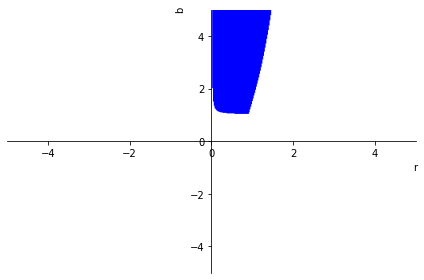

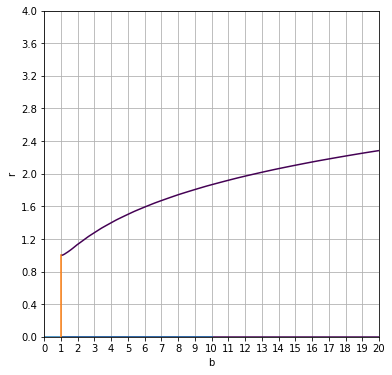

In [3]:
print('Community Matrix\n')
pprint(comm_mat_simple, use_unicode=false)
print('\n')
print('Characteristic Equation\n')
pprint(chareq, use_unicode=false)
print('\n')
print('Coefficients of Characteristic Equation assuming b > 0\n')
pprint([a0, a1, a2, a3], use_unicode=False)
print('\n')
print("jury condition 1")
pprint(jury1, use_unicode=False)
print("*****************\n")

print("jury condition 2")
pprint(jury2, use_unicode=False)
print("*****************\n")

print("jury condition 3")
pprint(jury3, use_unicode=False)
print("*****************\n")

print("jury condition 4")
pprint(jury4, use_unicode=False)
print("*****************\n")

print("inequality plot implied by j1-j4 (r,b) space")
plot_implicit(ineq1 & ineq2 & ineq3 & ineq4)
print("*****************\n")

print("Cleaner plot using contour function (b,r) space")
print("1<b<10, 0<r<10")
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
bsp, rsp = np.meshgrid(np.linspace(1,20,180),np.linspace(0,4,40))
ax.contour(bsp,rsp,jury4num(bsp,rsp),[0],color='k')
ax.set_xlabel('b')
ax.set_ylabel('r')
ax.set_xlim(0,20)
ax.set_ylim(0,3)
ax.grid()
ax.plot(np.linspace(0,10,200), np.full(200,0))
ax.plot(np.full(200,1), np.linspace(0,1,200))
ax.set_xticks(np.linspace(0,20,21))
ax.set_yticks(np.linspace(0,4,11))
print("*****************\n")

Stability Analysis of the communal fixed point
J1 - J3 imply r>0 and b>1, which makes sense
biologically. J4 introduces a non linear inequality, which
is simplest to find numerically

Jacobian

⎡         0                  1                          0                 ⎤
⎢                                                                         ⎥
⎢        r⋅(1 - x)        r⋅(1 - x)                  r⋅(1 - x)            ⎥
⎢  -r⋅y⋅ℯ                ℯ                       -y⋅ℯ                     ⎥
⎢  ────────────────      ──────────              ──────────────           ⎥
⎢       z + 1              z + 1                           2              ⎥
⎢                                                   (z + 1)               ⎥
⎢                                                                         ⎥
⎢          r⋅(1 - x)        r⋅(1 - x)           r⋅(1 - x)        r⋅(1 - x)⎥
⎢-b⋅r⋅y⋅z⋅ℯ            b⋅z⋅ℯ             b⋅y⋅z⋅ℯ            b⋅y⋅ℯ         ⎥
⎢────────────────────  ──────────────  - ──────────────── + ──────────────⎥
⎢       z + 1              z + 1                    2           z + 1     ⎥
⎣                                            (z + 1)                      ⎦




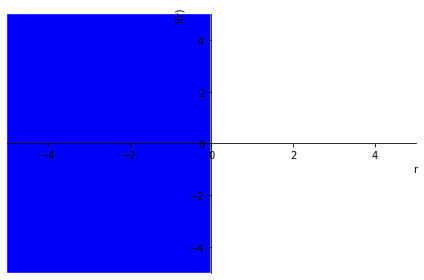

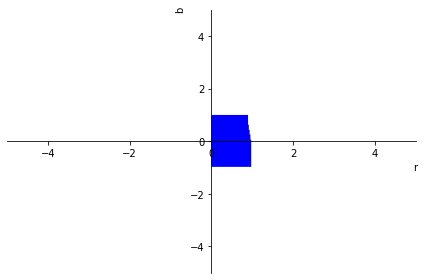

In [4]:
print('Jacobian\n')
pprint(jac)
print('\n')

print('Jacobian at (0,0,0)')
pprint(zero_mat)
print('\n')

print('Jacobian at (1,1,0)')
pprint(ext_mat)
print('\n')

print('Char Poly for (0,0,0)')
pprint(zero_char_eq)
pprint(zero_char_coeffs)
print('\n')

print('Char Poly for (1,1,0)')
pprint(ext_char_eq)
pprint(ext_char_coeffs)
print('\n')

jury1, jury2, jury3, jury4 = juries(zpt_coeffs)

print("jury condition 1 for (0,0,0)")
pprint(jury1, use_unicode=False)
print("*****************\n")

print("jury condition 2 for (0,0,0)")
pprint(jury2, use_unicode=False)
print("*****************\n")

print("jury condition 3 for (0,0,0)")
pprint(jury3, use_unicode=False)
print("*****************\n")

print("jury condition 4 for (0,0,0)")
pprint(jury4, use_unicode=False)
print("*****************\n")


jury1, jury2, jury3, jury4 = juries(extpt_coeffs)

print("jury condition 1 for (1,1,0)")
pprint(jury1, use_unicode=False)
print("*****************\n")

print("jury condition 2 for (1,1,0)")
pprint(jury2, use_unicode=False)
print("*****************\n")

print("jury condition 3 for (1,1,0)")
pprint(jury3, use_unicode=False)
print("*****************\n")

print("jury condition 4 for (1,1,0)")
pprint(jury4, use_unicode=False)
print("*****************\n")

plot_implicit(ineqs(juries(zpt_coeffs))[0] & ineqs(juries(zpt_coeffs))[1] & ineqs(juries(zpt_coeffs))[2] & ineqs(juries(zpt_coeffs))[3])
plot_implicit(ineqs(juries(extpt_coeffs))[0] & ineqs(juries(extpt_coeffs))[1] & ineqs(juries(extpt_coeffs))[2] & ineqs(juries(extpt_coeffs))[3])

Stabiility Analysis of (0,0,0) and (1,1,0)

<ipython-input-5-172aef2a93b9>:6: UserWarning: The following kwargs were not used by contour: 'color'
  ax.contour(bsp,rsp,jury4num(bsp,rsp),[0],color='k')


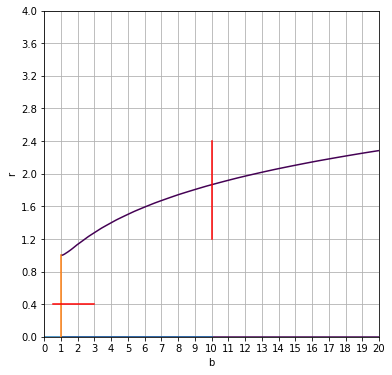

In [5]:
r_fixed = .4
b_fixed = 10
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
bsp, rsp = np.meshgrid(np.linspace(1,20,180),np.linspace(0,4,40))
ax.contour(bsp,rsp,jury4num(bsp,rsp),[0],color='k')
ax.set_xlabel('b')
ax.set_ylabel('r')
ax.set_xlim(0,20)
ax.set_ylim(0,3)
ax.grid()
ax.plot(np.linspace(0,10,200), np.full(200,0))
ax.plot(np.full(200,1), np.linspace(0,1,200))
ax.set_xticks(np.linspace(0,20,21))
ax.set_yticks(np.linspace(0,4,11))
ax.plot([.5, 3],[r_fixed,r_fixed],color='r')
ax.plot([b_fixed,b_fixed],[1.2,2.4],color='r')


Bifurcation Analysis I - Selecting Regions to over which to
plot the bifurcation

We will consider one bifurcation across the vertical line, and then
examine several bifurcations across the curve, where b is varied.
ie, we will be dragging the vertical line horizontally

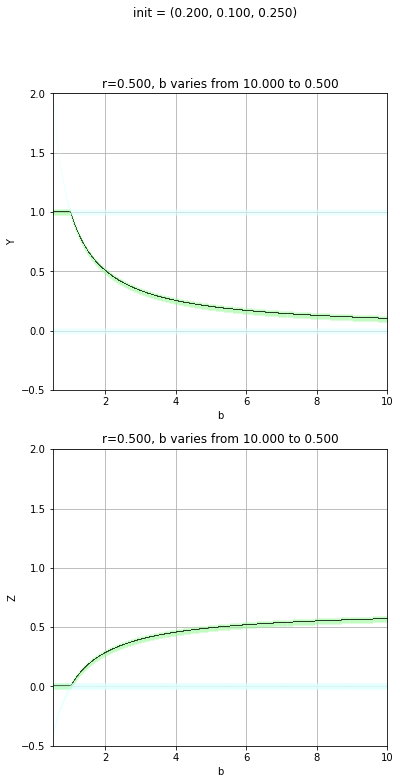

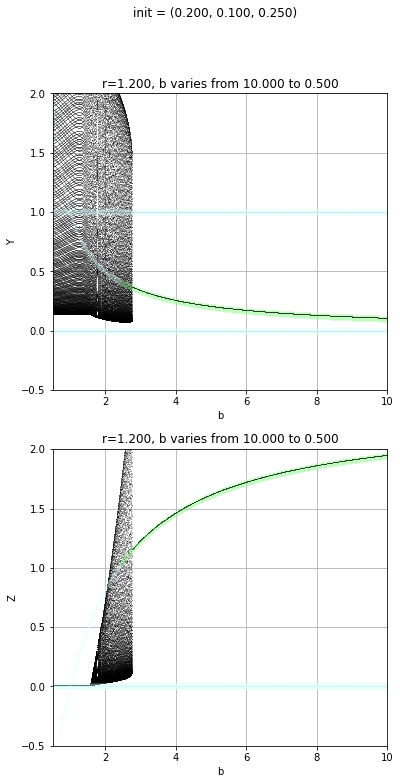

In [6]:
n = 1000
its = 2000
k= 300
inits = [(.2,.1,.25)]
r_fixed = .5
bmin = .5
bmax = 10
ymin = -.5
ymax = 2

plot_bfs_b(inits,n,its,k,bmax,bmin,r_fixed,ymin,ymax)
r_fixed = 1.2
plot_bfs_b(inits,n,its,k,bmax,bmin,r_fixed,ymin,ymax)
    #   TODO: Refactor this so that you don't have to order of bmin,bmax

Bifurcation Analysis II - Transcritical Bifurcations
Note: colored lines are the fixed points of the map
      cyan => unstable, green => stable

first plot is a local transcritical bf- collision of fixed points
second plot is a global transcritical bf- collision of invariant circles with fixed point


In [8]:
r_fixed = .4
bvals = [.8,1.2]
coords1 = []
for bval in bvals:
    v_coord = (bval,r_fixed)
    coords1.append(v_coord)

print_eigs(coords1)


(0.8,0.4)
[0.45036+0.46076j 0.45036-0.46076j 1.20445+0.j     ]
modulus of eigs
[0.6443, 0.6443, 1.20445]
*******

(1.2,0.4)
[0.59199+0.30511j 0.59199-0.30511j 0.75153+0.j     ]
modulus of eigs
[0.66599, 0.66599, 0.75153]
*******



Some eigenvalues around the transcritical bifurcation

Bifurcation Analysis III - Bifurcations across the curve
    * b=.9, .5<r<3
    * b=1.1, .5<r<3
    * b=1.1, 1<r<2.5 (zomming in from above plot)
    * b=2, .5<r<3
    * b=2, 1<r<1.7 (zooming in from above plot)
    * b=3, .5<r<3
    * b=4, .5<r<3
    * b=10, .5<r<3

    Note: Bifurcations not yet classified

#TODO- In below discussions, include the eigenvalues when topical in below discussions

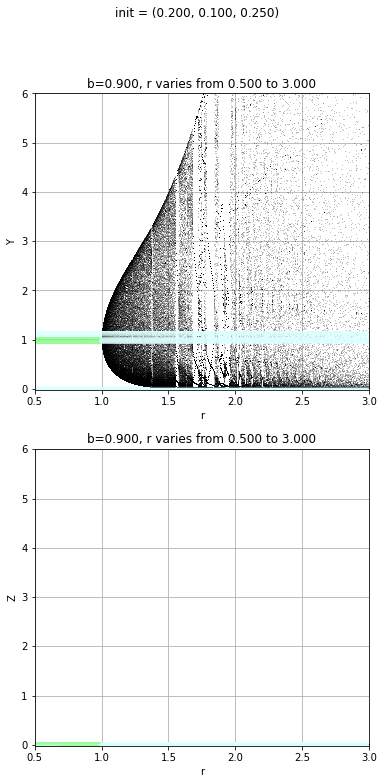

In [9]:
n = 1000
its = 2000
k= 300
inits = [(.2,.1,.25)]
# b_fixed = 10
rmin = .5
rmax = 3

plot_bfs_r(inits,n,its,k,rmin,rmax,b_fixed=.9,ymin=-.02,ymax=6)

For b < 1 (.9), we see that the point at
(1,1,0) is stable, and the hosts/parasites
follow that point. When the point loses stability,
(through a transcritical bifurcation due to
collision with coexistence point)
it creates invariant circles in the host.
the parasite is extinct for all values of r

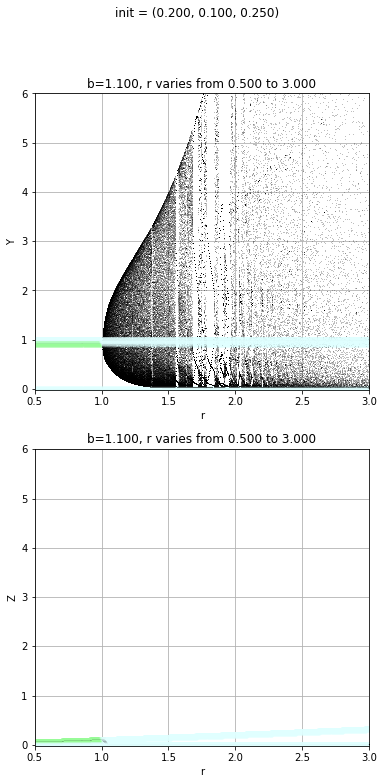

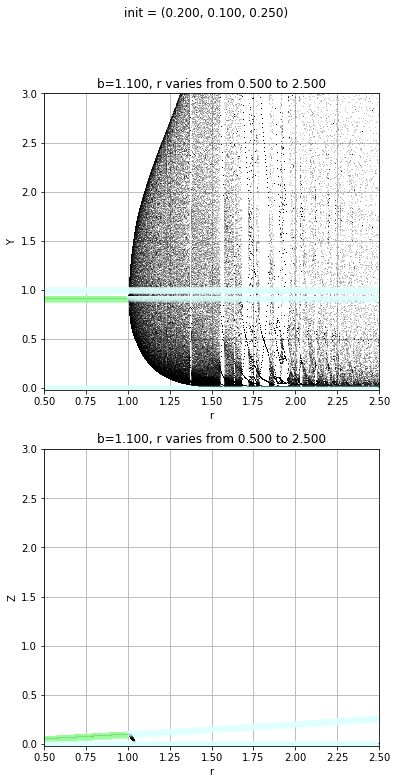

In [10]:
plot_bfs_r(inits,n,its,k,rmin,rmax,b_fixed=1.1,ymin=-.02,ymax=6)
plot_bfs_r(inits,n,its,k,rmin=.5,rmax=2.5,b_fixed=1.1,ymin=-.02,ymax=3)

For b=1.1, the diagram appears to show a hopf occuring
however closer inspection reveals some unexpected behavior
Note the abrupt exit from the stable communal
fixed point when that point loses its stability

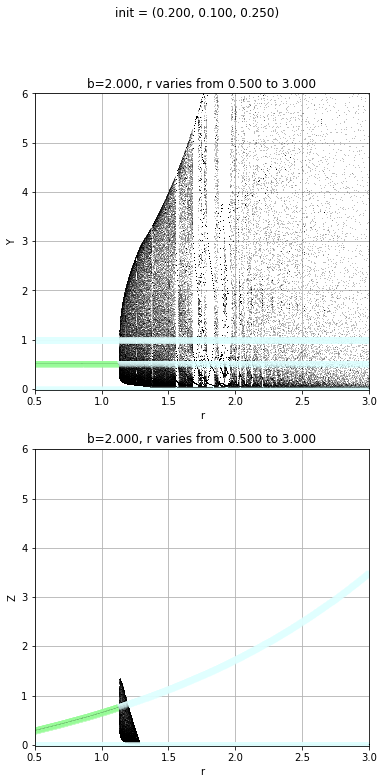

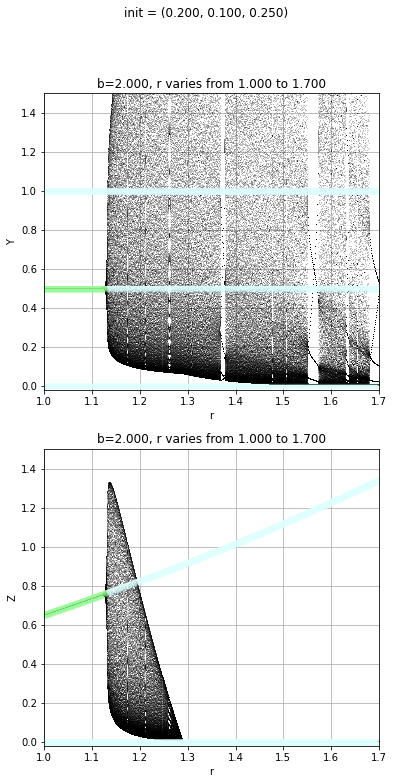

In [11]:
plot_bfs_r(inits,n,its,k,rmin,rmax,b_fixed=2,ymin=-.02,ymax=6)
plot_bfs_r(inits,n,its,k,rmin=1,rmax=1.7,b_fixed=2,ymin=-.02,ymax=1.5)

In [12]:
b_fixed = 2
rvals = [1.02,1.22]
coords = []
for rval in rvals:
    v_coord = (b_fixed,rval)
    coords.append(v_coord)

print_eigs(coords)


(2,1.02)
[0.52732+0.81009j 0.52732-0.81009j 0.54585+0.j     ]
modulus of eigs
[0.9666, 0.9666, 0.54585]
*******

(2,1.22)
[0.48151+0.90514j 0.48151-0.90514j 0.58033+0.j     ]
modulus of eigs
[1.02525, 1.02525, 0.58033]
*******



Some eigenvalues near bifurcation

For b=2, the diagram is similar to 1.1, however
the drastic change in behavior is not as smooth,
and if you look closely, the divergent behavior
is actually occurring before the communal fixed point loses
stability

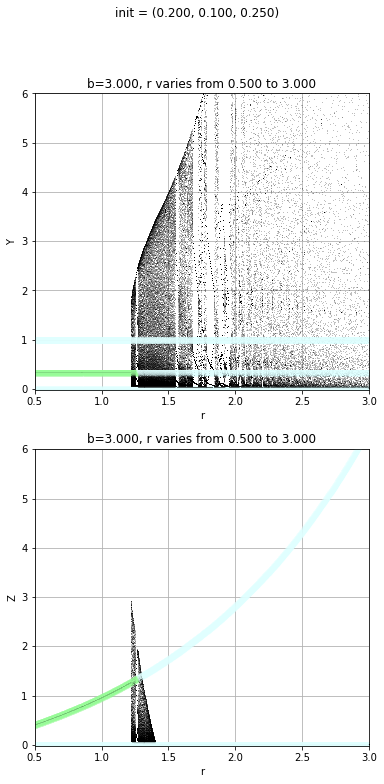

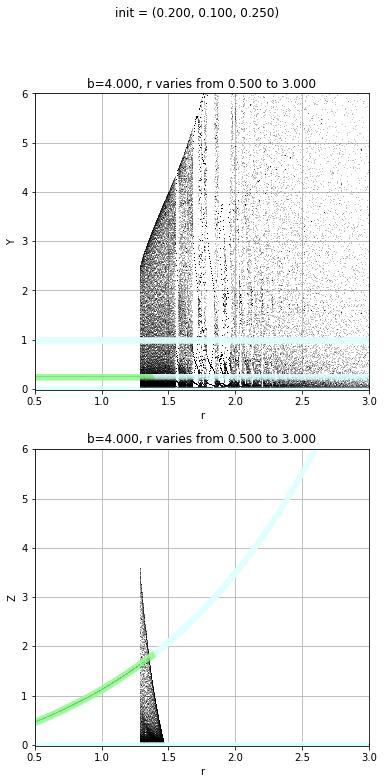

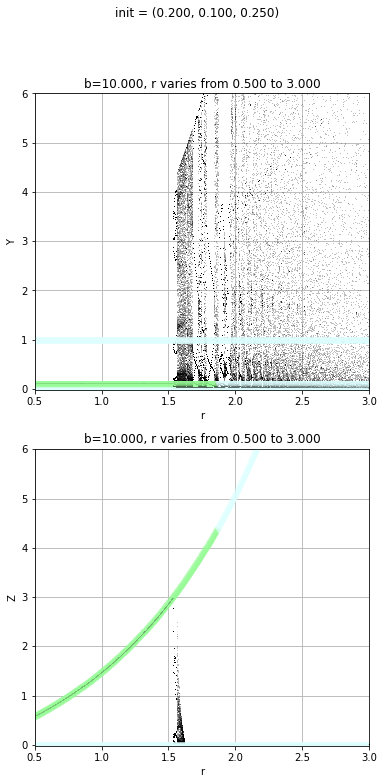

In [13]:
plot_bfs_r(inits,n,its,k,rmin,rmax,b_fixed=3,ymin=-.02,ymax=6)
plot_bfs_r(inits,n,its,k,rmin,rmax,b_fixed=4,ymin=-.02,ymax=6)
plot_bfs_r(inits,n,its,k,rmin,rmax,b_fixed=10,ymin=-.02,ymax=6)
#   TODO: Option to choose only one of host or
    # parasite in plot

The lack of smoothness becomes more pronounced
as b increases past 2 (3,4,10)
The transition keeps occurring earlier and earlier,
before the fixed point actually loses stability.
This implies the possibility of another attractor
in the map, outside of the known fixed points

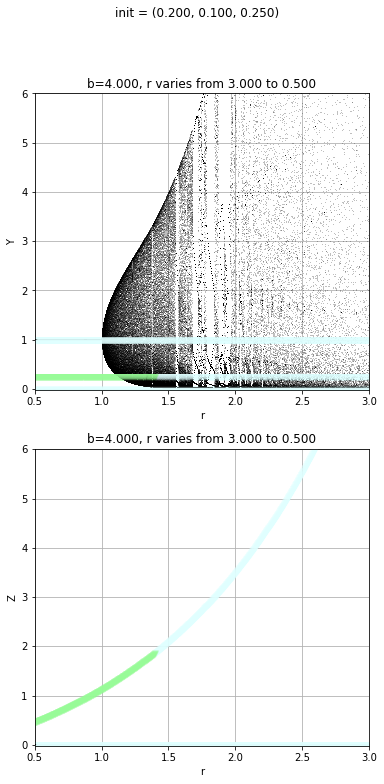

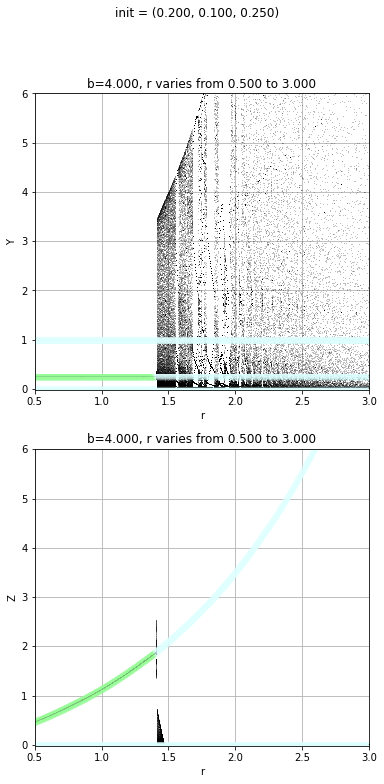

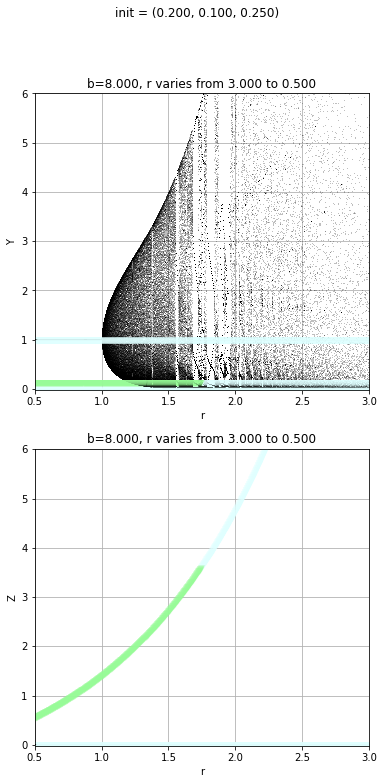

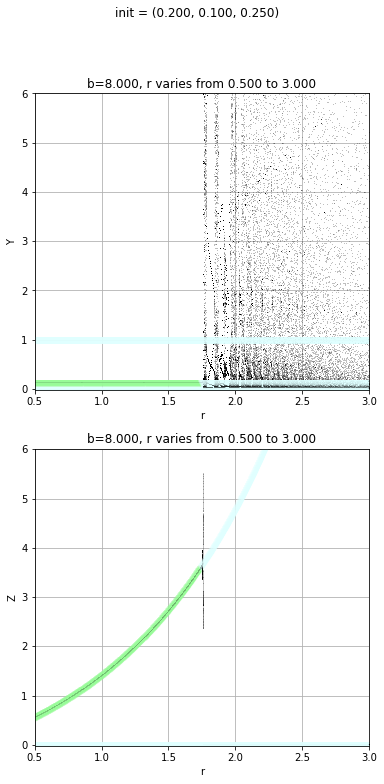

In [14]:
plot_bfs_r(inits,n,its,k,rmin=3,rmax=.5,b_fixed=4,ymin=-.02,ymax=6,initUpdate=True, flipAx=True)
plot_bfs_r(inits,n,its,k,rmin=.5,rmax=3,b_fixed=4,ymin=-.02,ymax=6,initUpdate=True)
plot_bfs_r(inits,n,its,k,rmin=3,rmax=.5,b_fixed=8,ymin=-.02,ymax=6,initUpdate=True, flipAx=True)
plot_bfs_r(inits,n,its,k,rmin=.5,rmax=3,b_fixed=8,ymin=-.02,ymax=6,initUpdate=True)

Note that when we update inits, and start from the left,  the change in behavior corresponds
to the change in stability of the fixed point

When we start from the right and update inits, we remain on
invariant circles even after the fixed point becomes stable

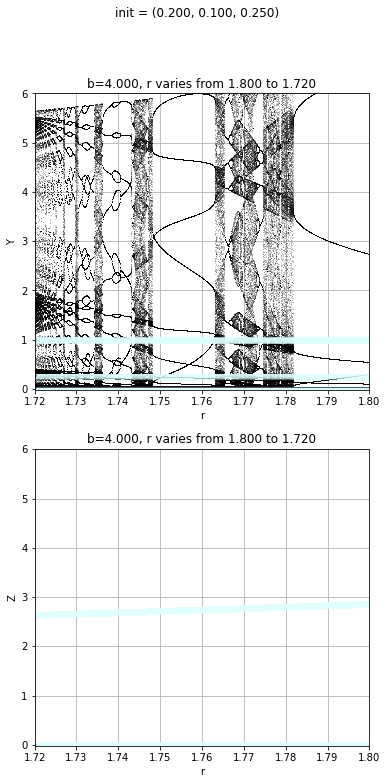

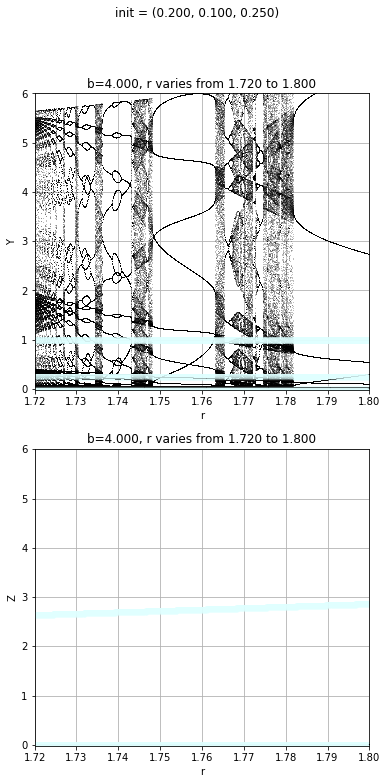

In [15]:
k=750
plot_bfs_r(inits,n,its,k,rmin=1.8,rmax=1.72,b_fixed=4,ymin=-.02,ymax=6,initUpdate=True, flipAx=True)
plot_bfs_r(inits,n,its,k,rmin=1.72,rmax=1.8,b_fixed=4,ymin=-.02,ymax=6,initUpdate=True)

blowing up the diagram to see potential chaos

We run the bifurcation diagram backwards (starting
on the invariant circles) and update the next initial
condition each time we update the parameter. The idea here
is to see bifurcations where the orbits hit the other attractor
running bacward for b=4 and b=8

These diagrams imply 2 attractors, one being the known
fixed point, the other not related to the fixed point.

Possibly a cyclic fold bifurcation

In [16]:
import warnings
warnings.filterwarnings('ignore')

rmin = .5
rmax = 5.5
# n=10
n=5
bmin = 3
bmax = 8
# m=10
m=5
its = 375
k = 375
# inits = [(.2,.1,.25), (.25,.1,.25), (.5,.1,.3),
#          (.11,.05,1.5),(.5,.8,.9),(.5,.1,.9),
#          (.05,.8,.1), (.7,.2,.77), (.04,.08,.72),
#          (.12,.23,.5),(.72,.1,.11),(.9,.12,.21),
#          (1.2,.5,2.1),(.9,1.4,3.5),(1.1,.4,5.2),
#          (.25,4,.9), (1.2,5,.7), (1.1,1.05,8)]

inits = [(.2,.1,.25)]

for init in inits:
    print("initial condition = {}".format(init))
    lyapunovs_big(init,rmin,rmax,bmin,bmax,its,k,n,m)

initial condition = (0.2, 0.1, 0.25)
The Method is starting
Done


Searching for chaotic orbits...
The above method takes a list of inits, and for each
checks lyaps of orbits over a grid in r,b space

(see attached .txt for non trivial results)

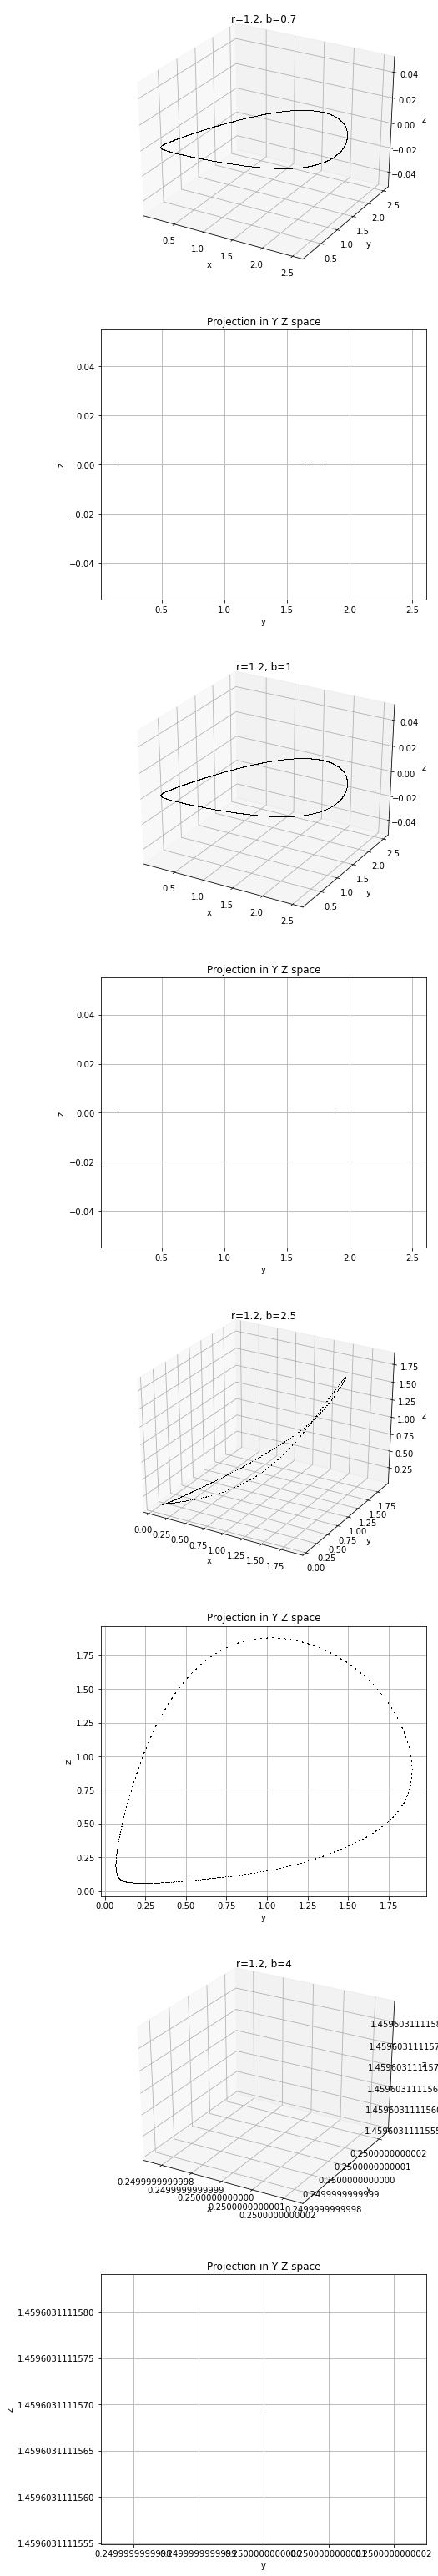

In [17]:
inits = [(.2,.1,.25,1.2,.7),
        (.2,.1,.25,1.2,1),
         (.2,.1,.25,1.2,2.5),
         (.2,.1,.25,1.2,4)
         ]
k = 2000
its = 10000

plot_orbits(inits,its,k)

Trying some Orbits with the inits and params found

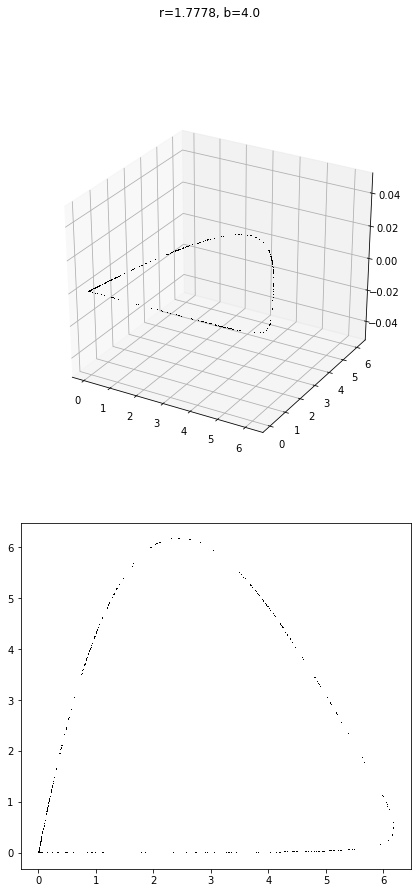

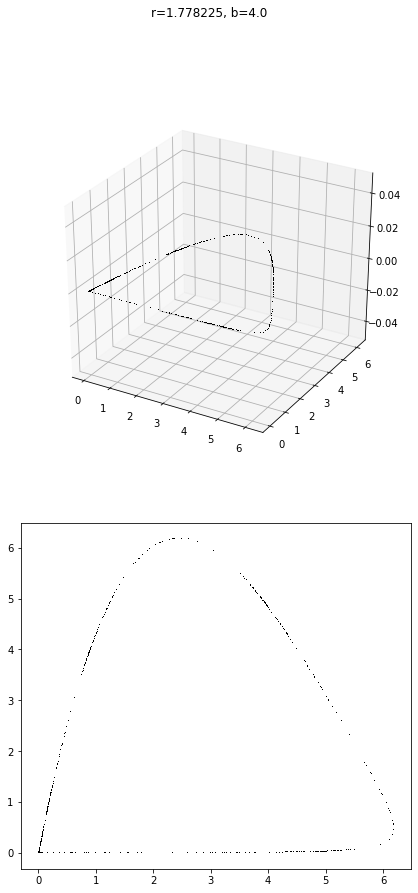

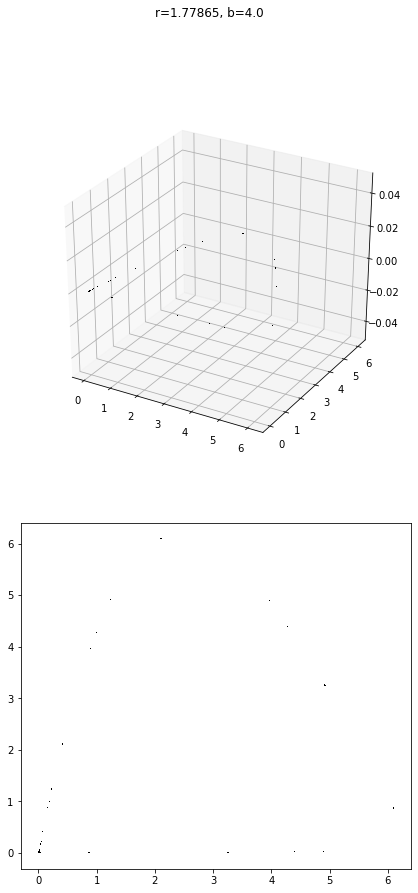

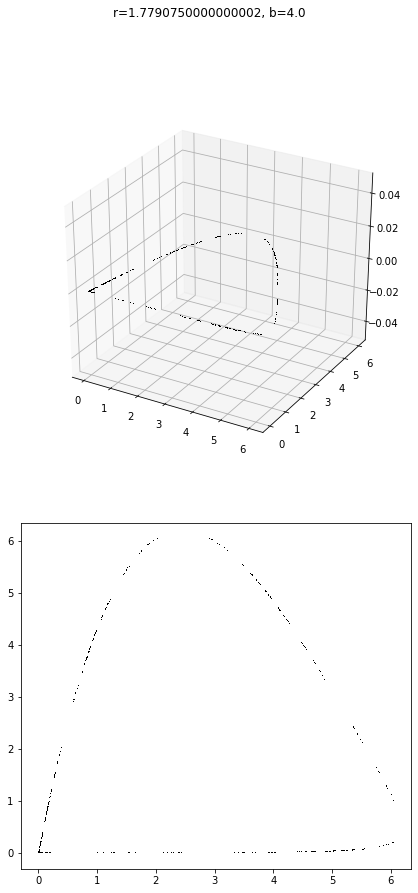

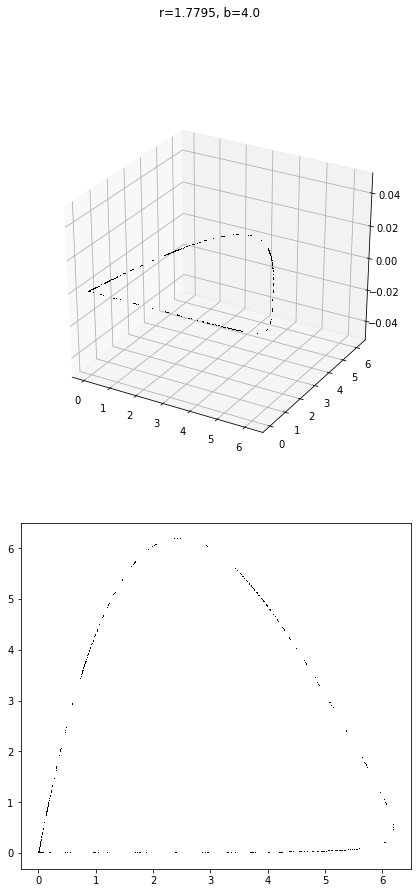

In [21]:
# rpts = [1.76857, 1.734625, 1.72987]
rpts = np.linspace(1.7778,1.7795,5)
bpt = 4.0
k = 1000
its = 2000
inits = [(0.86, 0.9, .05)]
for rpt in rpts:
    plot_orbs_1ax(inits,rpt,bpt,its,k)       

trying multiple nearby initial conditions on one plot..









